<a href="https://colab.research.google.com/github/hasitanalluri/mlgroupproject/blob/main/ML_Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We downloaded our dataset from https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh/about_data
df = pd.read_csv('/content/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20250227.csv')
#print(df.head())

In [2]:
print(df.shape)
threshold = 0.5  # Drop columns with more than 50% NaN values
df = df.loc[:, df.isnull().mean() < threshold]
print(df.shape)

(81713, 135)
(81713, 134)


In [3]:
# Remove missing observations
print("Original df size:", df.shape)
print(df[['critical_staffing_shortage_today_yes', 'critical_staffing_shortage_today_no']].isnull().any(axis=1).sum())
df = df.dropna(subset=['critical_staffing_shortage_today_yes', 'critical_staffing_shortage_today_no'])
print("New df size:", df.shape)

Original df size: (81713, 134)
0
New df size: (81713, 134)


In [4]:
# Create new variable, proportion of hospitals experiencing critical staffing shortages
df['critical_staffing_shortage_today_prop'] = df['critical_staffing_shortage_today_yes'] / (df['critical_staffing_shortage_today_yes'] + df['critical_staffing_shortage_today_no'])

In [5]:
# Clean data for the number of inpatient beds utilized (inpatient_beds_utilization)
print("Original df size:", df.shape)
print(df[['inpatient_beds_utilization']].isnull().any(axis=1).sum())
df = df.dropna(subset=['inpatient_beds_utilization'])
print("New df size:", df.shape)

Original df size: (81713, 135)
265
New df size: (81448, 135)


In [6]:
# Number of COVID-19 patients (inpatient) per hospital

# Remove missing observations
print("Original df size:", df.shape)
print(df[['inpatient_beds_used_covid', 'inpatient_beds_used_covid_coverage']].isnull().any(axis=1).sum())
df = df.dropna(subset=['inpatient_beds_used_covid', 'inpatient_beds_used_covid_coverage']).copy()
print("New df size:", df.shape)

df['covid_patients_per_hospital'] = df['inpatient_beds_used_covid'] / (df['inpatient_beds_used_covid_coverage'])
df['covid_patients_per_hospital'].describe()

Original df size: (81448, 135)
767
New df size: (80681, 135)


,covid_patients_per_hospital
count,80681.000000
mean,7.232179
std,8.618627
min,0.000000
25%,2.115385
50%,4.566265
75%,8.947368
max,165.333333


In [7]:
# Normalize all numerical variables
from sklearn.preprocessing import MinMaxScaler

# Create a scaler
scaler = MinMaxScaler()

# Select only numerical columns
num_cols = df.select_dtypes(include=['number']).columns

# Fit and transform the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

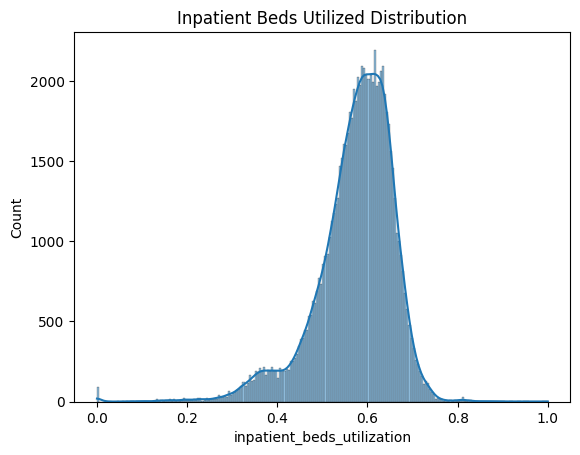

In [8]:
sns.histplot(data=df, x='inpatient_beds_utilization', kde=True)
plt.title('Inpatient Beds Utilized Distribution')
plt.show()

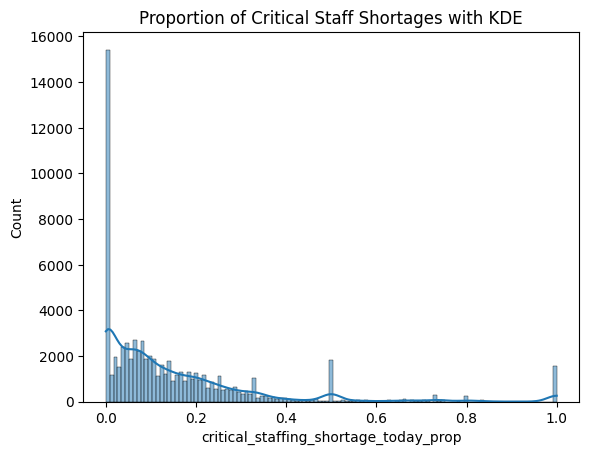

In [9]:
sns.histplot(data=df, x='critical_staffing_shortage_today_prop', kde=True)
plt.title('Proportion of Critical Staff Shortages with KDE')
plt.show()

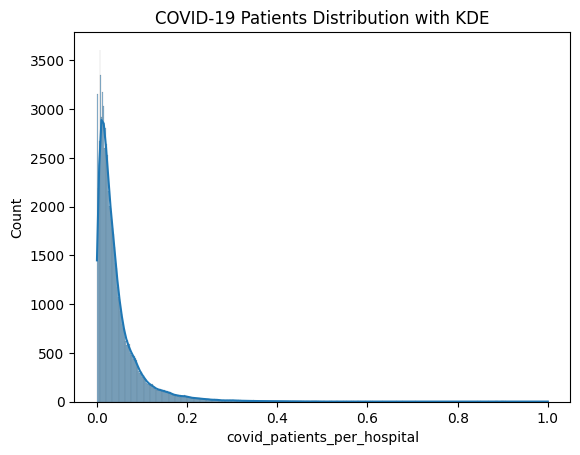

In [10]:
sns.histplot(data=df, x='covid_patients_per_hospital', kde=True)
plt.title('COVID-19 Patients Distribution with KDE')
plt.show()

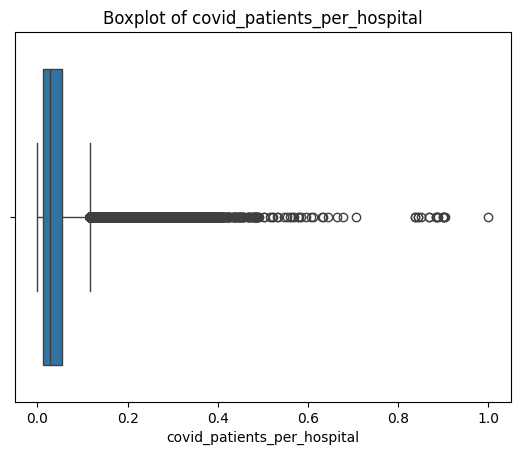

In [11]:
# See outliers
sns.boxplot(x=df['covid_patients_per_hospital'])
plt.title(f'Boxplot of covid_patients_per_hospital')
plt.show()

<Axes: xlabel='covid_patients_per_hospital', ylabel='Count'>

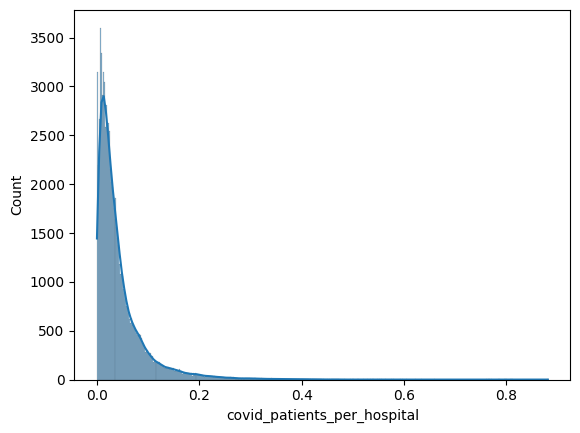

In [12]:
# Address outliers by calculating arcsinh
df = df.copy()
df['covid_patients_per_hospital'] = np.arcsinh(df['covid_patients_per_hospital'])
sns.histplot(data=df, x='covid_patients_per_hospital', kde=True)

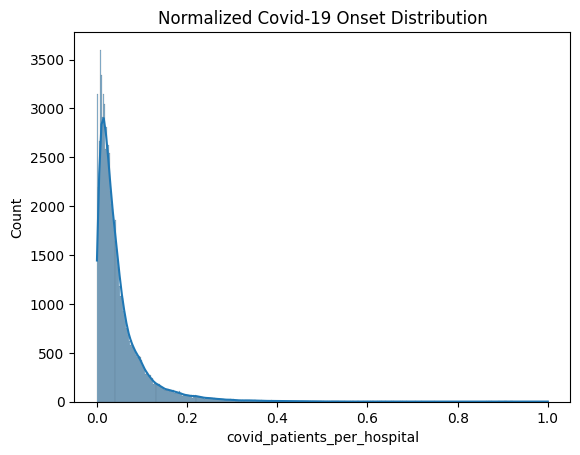

In [13]:
# Normalize covid_patients_per_hospital
scaler = MinMaxScaler()
df['covid_patients_per_hospital'] = scaler.fit_transform(df[['covid_patients_per_hospital']])
sns.histplot(data=df, x='covid_patients_per_hospital', kde=True)
plt.title('Normalized Covid-19 Onset Distribution')
plt.show()

In [14]:
print(df.shape)
df = df.dropna(subset=['critical_staffing_shortage_today_prop', 'inpatient_beds_utilization', 'covid_patients_per_hospital'])
print(df.shape)

(80681, 136)
(70744, 136)


In [15]:
# Linear regression model to predict # COVID-19 patients in hospital based off of number of beds used and critical staff shortages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df[['critical_staffing_shortage_today_prop', 'inpatient_beds_utilization']]
y = df['covid_patients_per_hospital'] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
print("R squared:",reg.score(X_test, y_test)) # R squared measure on test set

# Compute RMSE
y_test_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

R squared: 0.1114675658467974
RMSE: 0.05325516372943084


Linear model performed poorly.

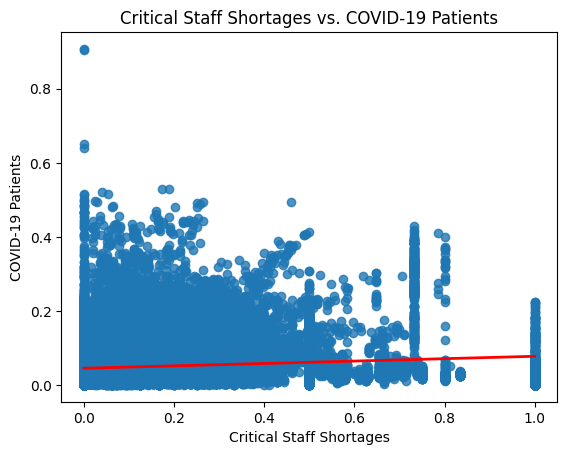

In [16]:
# Scatterplot with line of best fit
sns.regplot(x=df['critical_staffing_shortage_today_prop'],
            y=df['covid_patients_per_hospital'],
            line_kws={'color': 'red', 'linewidth': 2})

# Add title and labels
plt.title('Critical Staff Shortages vs. COVID-19 Patients')
plt.xlabel('Critical Staff Shortages')
plt.ylabel('COVID-19 Patients')

# Show the plot
plt.show()

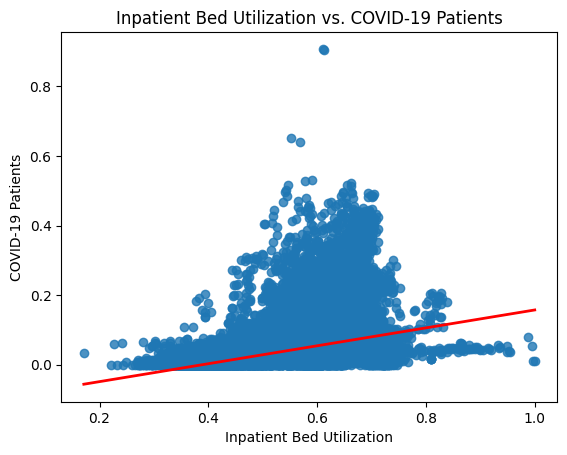

In [17]:
# Scatterplot with line of best fit
sns.regplot(x=df['inpatient_beds_utilization'],
            y=df['covid_patients_per_hospital'],
            line_kws={'color': 'red', 'linewidth': 2})

# Add title and labels
plt.title('Inpatient Bed Utilization vs. COVID-19 Patients')
plt.xlabel('Inpatient Bed Utilization')
plt.ylabel('COVID-19 Patients')

# Show the plot
plt.show()

In [18]:
df.columns

Index(['state', 'date', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'hospital_onset_covid_coverage',
       ...
       'previous_day_admission_pediatric_covid_confirmed_unknown',
       'previous_day_admission_pediatric_covid_confirmed_unknown_coverage',
       'staffed_icu_pediatric_patients_confirmed_covid',
       'staffed_icu_pediatric_patients_confirmed_covid_coverage',
       'staffed_pediatric_icu_bed_occupancy',
       'staffed_pediatric_icu_bed_occupancy_coverage',
       'total_staffed_pediatric_icu_beds',
       'total_staffed_pediatric_icu_beds_coverage',
       'critical_staffing_shortage_today_prop', 'covid_patients_per_hospital'],
      dtype='o

In [19]:
df['state'].unique()

array(['MA', 'WY', 'LA', 'RI', 'KS', 'ME', 'MS', 'SD', 'ID', 'ND', 'AK',
       'NE', 'NH', 'DC', 'MN', 'IA', 'NM', 'NV', 'CO', 'MT', 'HI', 'DE',
       'NC', 'WV', 'OR', 'CT', 'MD', 'PR', 'SC', 'VT', 'VI', 'NJ', 'OK',
       'AS', 'UT', 'WA', 'AL', 'WI', 'MI', 'AR', 'KY', 'NY', 'OH', 'MO',
       'FL', 'PA', 'TX', 'CA', 'TN', 'IN', 'VA', 'AZ', 'GA', 'IL'],
      dtype=object)

In [20]:
# Include state as variable in linear model
df_dummies = pd.get_dummies(df['state'],dtype='int')

df = df.dropna(subset=['state'])

X = pd.concat([df[['critical_staffing_shortage_today_prop', 'inpatient_beds_utilization']], df_dummies], axis=1)
y = df['covid_patients_per_hospital'] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
print("R squared:",reg.score(X_test, y_test)) # R squared measure on test set

# Compute RMSE
y_test_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

R squared: 0.34315761884926965
RMSE: 0.04578842074808834


Linear model performs significantly better with states included.

In [21]:
df.columns

Index(['state', 'date', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'hospital_onset_covid_coverage',
       ...
       'previous_day_admission_pediatric_covid_confirmed_unknown',
       'previous_day_admission_pediatric_covid_confirmed_unknown_coverage',
       'staffed_icu_pediatric_patients_confirmed_covid',
       'staffed_icu_pediatric_patients_confirmed_covid_coverage',
       'staffed_pediatric_icu_bed_occupancy',
       'staffed_pediatric_icu_bed_occupancy_coverage',
       'total_staffed_pediatric_icu_beds',
       'total_staffed_pediatric_icu_beds_coverage',
       'critical_staffing_shortage_today_prop', 'covid_patients_per_hospital'],
      dtype='o

In [22]:
columns_with_missing = df.columns[df.isnull().any()]
print(columns_with_missing)

# Drop all columns with missing values
df = df.dropna(axis=1)

Index(['previous_day_admission_adult_covid_confirmed',
       'previous_day_admission_adult_covid_suspected',
       'previous_day_admission_pediatric_covid_confirmed',
       'previous_day_admission_pediatric_covid_suspected',
       'staffed_adult_icu_bed_occupancy',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid',
       'staffed_icu_adult_patients_confirmed_covid',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
       'total_adult_patients_hospitalized_confirmed_covid',
       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid',
       'total_pediatric_patients_hospitalized_confirmed_covid',
       'total_staffed_adult_icu_beds', 'adult_icu_bed_covid_utilization',
       'adult_icu_bed_covid_utilization_coverage',
       'adult_icu_bed_covid_utilization_numerator',
       'adult_icu_bed_covid_utilization_denominator',
       'adult_icu_bed_utilization', 'adult_icu_bed_utilization_coverage',
       'adult_icu_bed_utiliza

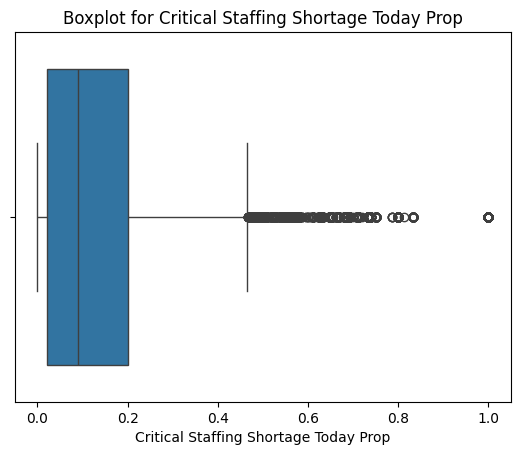

count    70744.000000
mean         0.150072
std          0.193158
min          0.000000
25%          0.022222
50%          0.090475
75%          0.200000
max          1.000000
Name: critical_staffing_shortage_today_prop, dtype: float64


In [23]:
# Logistic regression to predict hospital strain
# Determine criteria for high and low strain

# Boxplot
sns.boxplot(x=df['critical_staffing_shortage_today_prop'])
plt.title('Boxplot for Critical Staffing Shortage Today Prop')
plt.xlabel('Critical Staffing Shortage Today Prop')
plt.show()

# Five-number summary
five_num_summary = df['critical_staffing_shortage_today_prop'].describe()
print(five_num_summary)

75% is 0.2, meaning that 75% of all hospitals in a state that day are experiencing a critical staff shortage of 20% or less. We will define 'high strain' as when a state is in the upper quartile for critical_staffing_shortage_today_prop, meaning more than 20% of hospitals in that state on that day are experiencing a critical staffing shortage."

In [24]:
# Create variable, strain
df['strain'] = (df['critical_staffing_shortage_today_prop'] > 0.2).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_glm/_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.13944e-17): result may not be accurate.
  warnings.warn(


Accuracy on training data:  0.8903260005300822
Accuracy on test data:  0.8896035055480953


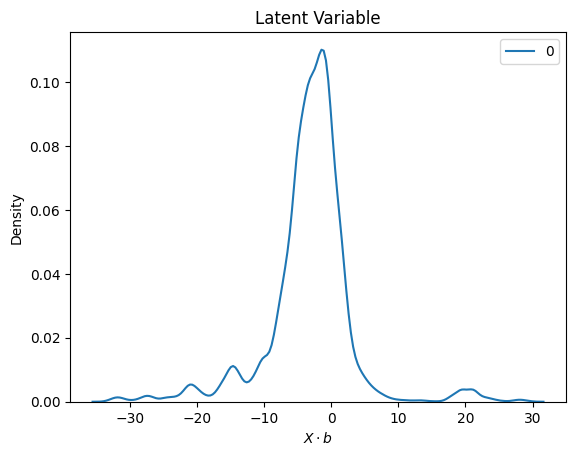

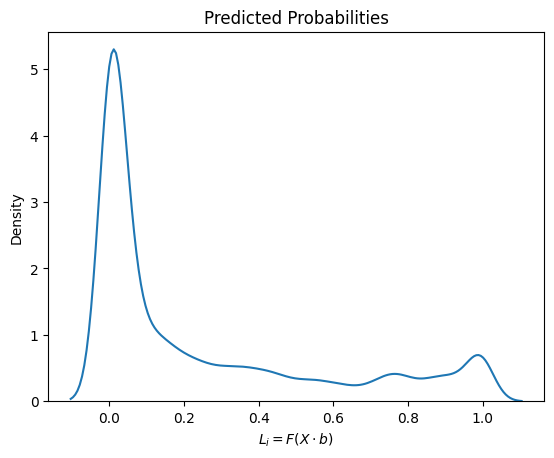

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.select_dtypes(include=['number'])
X = X.drop(['critical_staffing_shortage_today_prop',
             'critical_staffing_shortage_today_yes',
             'critical_staffing_shortage_today_no', 'strain'], axis=1)

# Include state as variable in log model
df_dummies = pd.get_dummies(df['state'],dtype='int')
df = df.dropna(subset=['state'])
X = pd.concat([X, df_dummies], axis=1)

y = df['strain'] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LogisticRegression(penalty=None,
                         fit_intercept=True,
                         solver='newton-cholesky',
                         max_iter=1000).fit(X_train, y_train)

print('Accuracy on training data: ', reg.score(X_train, y_train))
print('Accuracy on test data: ', reg.score(X_test, y_test))

latent = np.matmul( X, reg.coef_.T  ) + reg.intercept_
sns.kdeplot(latent).set_title('Latent Variable')
plt.xlabel("$X \\cdot b$")
plt.show()

# Probability of critical staff shortage:
pr_hat = 1/(1+np.exp(-latent[0]))
sns.kdeplot(x=pr_hat).set_title('Predicted Probabilities')
plt.xlabel("$L_i = F(X \\cdot b$)")
plt.show()

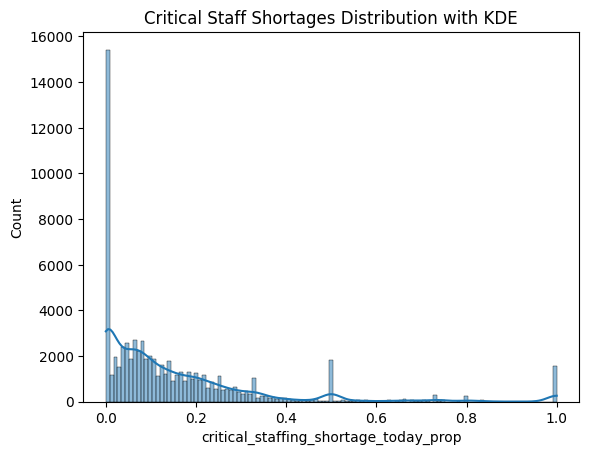

In [26]:
sns.histplot(df['critical_staffing_shortage_today_prop'], kde=True)
plt.title('Critical Staff Shortages Distribution with KDE')
plt.show()

Logistic regression worked very well to predict strain on hospitals!

In [28]:
# Use random forests to determine what features are driving strain
from sklearn.ensemble import RandomForestRegressor

# Fit model:
model = RandomForestRegressor(max_depth=10) # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions

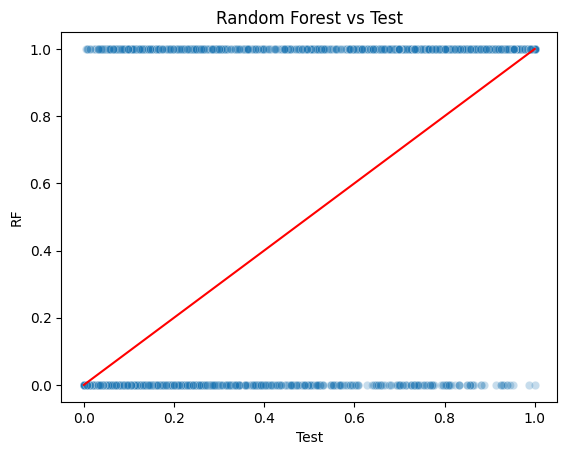

In [29]:
# Scatterplot of predicted v. actual:
import matplotlib.pyplot as plt
sns.scatterplot(y=y_test, x=y_hat_rf,alpha=.25).set(title='Random Forest vs Test', xlabel = 'Test', ylabel='RF') # Predicted v Actual

x_min = min(y_test)
x_max = max(y_test)
y_min = min(y_hat_rf)
y_max = max(y_hat_rf)
plt.plot([x_min, x_max], [y_min, y_max], color='red')

In [30]:
print( 'Rsq: ', rf.score(X_test,y_test) ) # Rsq measure

Rsq:  0.8238528490407132


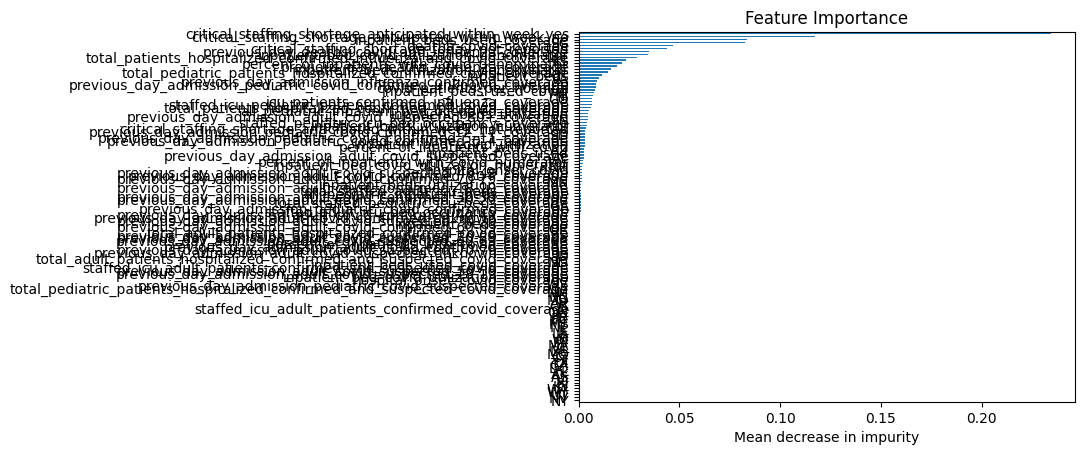

In [31]:
# Variable importance plot:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Mean decrease in impurity')
plt.show()

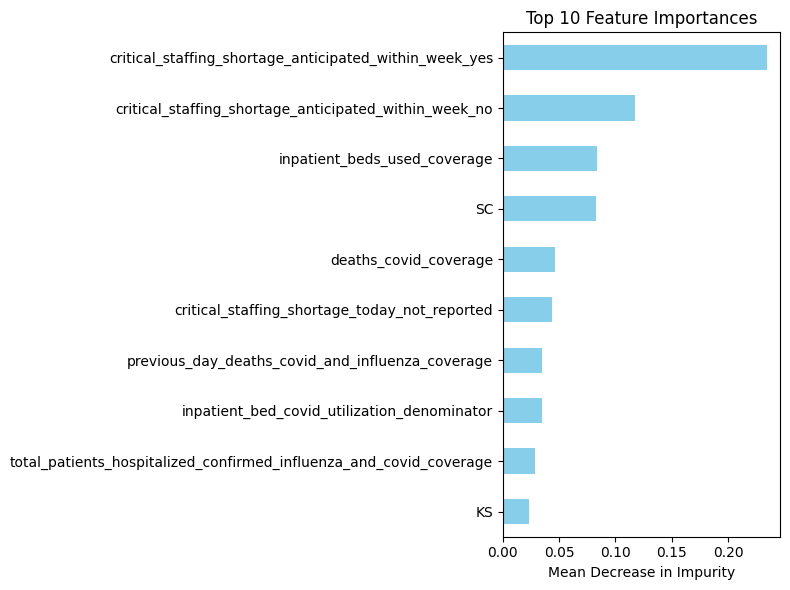

In [32]:
# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Select top 10 features
top_10_features = feature_importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
top_10_features.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 Feature Importances')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.show()

In [33]:
df.columns

Index(['state', 'date', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'hospital_onset_covid_coverage',
       'inpatient_beds', 'inpatient_beds_coverage', 'inpatient_beds_used',
       'inpatient_beds_used_coverage', 'inpatient_beds_used_covid',
       'inpatient_beds_used_covid_coverage',
       'previous_day_admission_adult_covid_confirmed_coverage',
       'previous_day_admission_adult_covid_suspected_coverage',
       'previous_day_admission_pediatric_covid_confirmed_coverage',
       'previous_day_admission_pediatric_covid_suspected_coverage',
       'staffed_adult_icu_bed_occupancy_coverage',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid

In [35]:
X_train['SC'].unique()

array([0, 1])

In [ ]:
# PCA to reduce dimensions

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

PCA = PCA()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # from previous X
X_pca = PCA.fit_transform(X_scaled)

y = df['covid_patients_per_hospital'] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X_pca,y, # uses the new pca'd predictors
                                                    test_size=.2,
                                                    random_state=65)

reg = LinearRegression().fit(X_train, y_train)
print("R squared:",reg.score(X_test, y_test))

# Compute RMSE
y_test_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)


R squared: 0.4715148337085385
RMSE: 0.3129795112248383


did better then the previous linear model w/ a select # of vars

R squared: 0.12420417270488782

RMSE: 0.051586033609331026